# Building movie recomendation machine learning models

To strengthen my skills in Machine Learning adn Exploratory Data Analysis, I will try to use Movie Lens 100k dataset to build 

### Contents:

1. [Imports & Exploratory Data Analasysis](#imports--exploratory-data-analysis)
2. [KNN](#knn)
    1. [Data preparation](#data-preprocessing)
    2. [Model](#model)
    3. [Testing](#testing)
3. SVD
    1. Data preparation
    2. Model
    3. Testing

## Imports & Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from fuzzywuzzy import process

### Datasets and their nan values

In [2]:
users = pd.read_csv('ml-100k\\u.user', sep='|', names=['user id', 'age', 'sex', 'occupation', 'zip code'])

print(f'\nThere are {users.shape[0]} users')
users.sample(5)


There are 943 users


,user id,age,sex,occupation,zip code
762,763,27,M,scientist,02113
817,818,28,M,librarian,27514
28,29,41,M,programmer,94043
619,620,18,F,writer,81648
665,666,44,M,administrator,61820


In [3]:
print('There are', users.shape[0], 'items in the dataset\n')

users.isna().sum()

There are 943 items in the dataset



user id       0
age           0
sex           0
occupation    0
zip code      0
dtype: int64

In [4]:
rating_cols = ['user id', 'movie id', 'rating', 'unix timestamp']

ratings_base = pd.read_csv('ml-100k\\ua.base', sep='\t', names=rating_cols)
ratings_test = pd.read_csv('ml-100k\\ua.test', sep='\t', names=rating_cols)

ratings = pd.concat([ratings_base, ratings_test])

print(f'There are {ratings.shape[0]} items in ratings dataset')

ratings.sample(10)

There are 100000 items in ratings dataset


,user id,movie id,rating,unix timestamp
15670,181,884,1,878961847
79596,830,202,5,891464148
9,1,10,3,875693118
42789,417,99,4,879647498
60576,606,25,5,878149689
11425,119,449,5,874782190
311,32,151,3,883717850
73747,756,323,3,874832096
37878,382,639,3,875946881
43860,429,217,3,882387715


In [5]:
print(ratings.isna().sum())

user id           0
movie id          0
rating            0
unix timestamp    0
dtype: int64


There are no missing values in the user and ratings datasets, which is great.

In [6]:
movies = pd.read_csv('ml-100k\\u.item', sep='|', names=['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
                                                    'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                                                    'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], encoding='latin-1')

movies.sample(5)

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
279,280,Up Close and Personal (1996),01-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Up%20Close%20...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1298,1299,Penny Serenade (1941),01-Jan-1941,NaN,http://us.imdb.com/M/title-exact?Penny%20Seren...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1425,1426,Grace of My Heart (1996),13-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Grace%20of%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1640,1641,Dadetown (1995),18-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Dadetown%20(1...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508,509,My Left Foot (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?My%20Left%20F...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print('There are', movies.shape[0], 'items in movies dataset\n')

movies.isna().sum()

There are 1682 items in movies dataset



movie id                 0
movie title              0
release date             1
video release date    1682
IMDb URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children's               0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
dtype: int64

We don't have any data for **video release date**, so we can just get rid of the column since it doesn't provide any info for us, other than that there is only 1 missing value for **release date** and 3 missing values for **IMDB URL**, which we can simply delete.

In [8]:
movies.drop(axis=1, labels='video release date', inplace=True)
movies.dropna(axis=0, inplace=True)

movies.isna().sum()

movie id        0
movie title     0
release date    0
IMDb URL        0
unknown         0
Action          0
Adventure       0
Animation       0
Children's      0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
dtype: int64

### What is the genre with the largest and the smallest number of movies made?

In [9]:
genres = ['Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
          'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

print(f'The genre with the largest number of movies made is {movies[genres].sum().sort_values(ascending=False).index[0]}')
print(f'The genre with the smallest number of movies made is {movies[genres].sum().sort_values(ascending=False).index[-1]}')

The genre with the largest number of movies made is Drama
The genre with the smallest number of movies made is Fantasy


### What is the genre with the biggest rating?

In [10]:
movie_ratings = ratings.merge(movies, on='movie id')
genre_ratings = {}

for genre in genres:
    genre_ratings[genre] = movie_ratings[movie_ratings[genre] == 1]['rating'].mean()

print(f'The genre with the biggest rating is {max(genre_ratings.items(), key=lambda x: x[1])[0]}')

The genre with the biggest rating is Film-Noir


### What is the average number of ratings per movie and per user?

In [11]:
n_ratings = len(ratings)
n_unique_users = ratings['user id'].nunique() 
n_unique_movies = ratings['movie id'].nunique()

print(f'There are {n_ratings} ratings, {n_unique_users} unique users and {n_unique_movies} unique movies\n')
print(f'Average number of ratings per movie {np.round(n_ratings/n_unique_movies, 2)}')
print(f'Average number of ratings per user {np.round(n_ratings/n_unique_users, 2)}')

There are 100000 ratings, 943 unique users and 1682 unique movies

Average number of ratings per movie 59.45
Average number of ratings per user 106.04


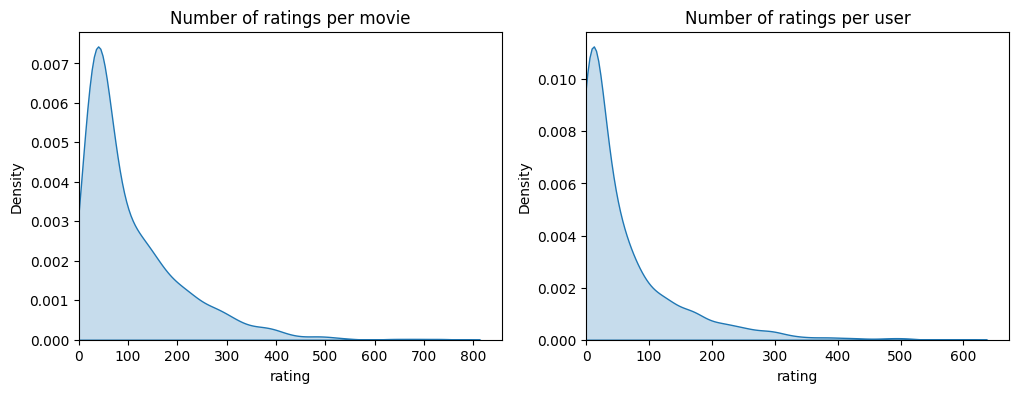

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
sns.kdeplot(ratings.groupby('user id')['rating'].count(), fill=True)
plt.xlim(0)
plt.title('Number of ratings per movie')

plt.subplot(1, 2, 2)
sns.kdeplot(ratings.groupby('movie id')['rating'].count(), fill=True)
plt.xlim(0)
plt.title('Number of ratings per user')

plt.show()

### What is the most common rating?

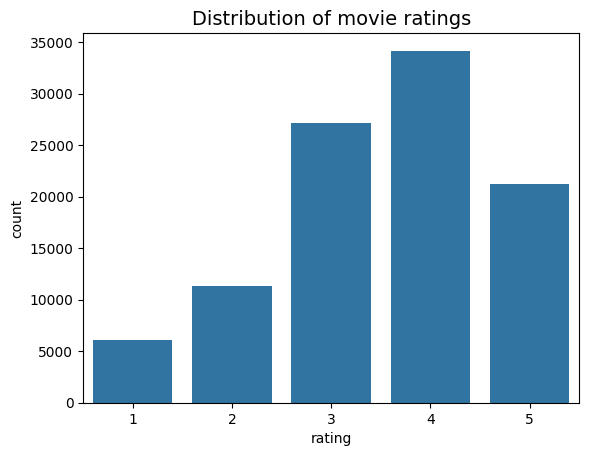

In [13]:
sns.countplot(data=ratings, x='rating')
plt.title('Distribution of movie ratings', fontsize=14)
plt.show()

Users rarely give movies low ratings like 1 and 2, they mostly give average or above average ratings of 3 and 4 respectively.

In [14]:
print(f'Mean rating {round(ratings['rating'].mean(), 2)}')

Mean rating 3.53


### In which year the largest amount of movies were released

In [29]:
year_of_release = movies['release date'].apply(lambda x: x.split('-')[-1])

print(f'The largest amount of movies were released in {year_of_release.value_counts().idxmax()} year')

0       1995
1       1995
2       1995
3       1995
4       1995
        ... 
1677    1998
1678    1998
1679    1998
1680    1994
1681    1996
Name: release date, Length: 1679, dtype: object
The largest amount of movies were released in 1996 year


### Which movies are most frequently ranked?

In [16]:
movie_ratings['movie title'].value_counts()[:10]

movie title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: count, dtype: int64

### What are the most high and most low ranked movies?

In [17]:
mean_ratings = ratings.groupby('movie id')[['rating']].mean()

print(f'Movie with the highest score is \"{movies[movies['movie id'] == mean_ratings['rating'].idxmax()][['movie title']].values[0][0]}\"')
print(f'Movie with the lowest score is \"{movies[movies['movie id'] == mean_ratings['rating'].idxmin()][['movie title']].values[0][0]}\"')

Movie with the highest score is "Great Day in Harlem, A (1994)"
Movie with the lowest score is "3 Ninjas: High Noon At Mega Mountain (1998)"


## KNN

### Data preprocessing

There are two common approaches to recommendation systems: collaborative and content-based filtering.

Collaborative filtering is based on the idea that similar people like similar things.
Content-based filtering considers items/users features.

To generate recommendations for users, we are going to use colaborative filtering, since it is robust and easier to implement.

In [18]:
# We merge the ratings, movies and users datasets to create a matrix with user ratings for each movie
movies_and_users = pd.merge(movie_ratings, users, on='user id')
movies_and_users = movies_and_users.pivot(index='user id', columns='movie id', values='rating').fillna(0)

movies_and_users

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
from scipy.sparse import csr_matrix

matrix_movies_users = csr_matrix(movies_and_users.values)

print(matrix_movies_users)

  (0, 0)	5.0
  (0, 1)	3.0
  (0, 2)	4.0
  (0, 3)	3.0
  (0, 4)	3.0
  (0, 5)	5.0
  (0, 6)	4.0
  (0, 7)	1.0
  (0, 8)	5.0
  (0, 9)	3.0
  (0, 10)	2.0
  (0, 11)	5.0
  (0, 12)	5.0
  (0, 13)	5.0
  (0, 14)	5.0
  (0, 15)	5.0
  (0, 16)	3.0
  (0, 17)	4.0
  (0, 18)	5.0
  (0, 19)	4.0
  (0, 20)	1.0
  (0, 21)	4.0
  (0, 22)	4.0
  (0, 23)	3.0
  (0, 24)	4.0
  :	:
  (942, 737)	4.0
  (942, 754)	2.0
  (942, 761)	4.0
  (942, 763)	3.0
  (942, 783)	2.0
  (942, 792)	3.0
  (942, 794)	3.0
  (942, 806)	4.0
  (942, 814)	4.0
  (942, 822)	4.0
  (942, 823)	3.0
  (942, 829)	2.0
  (942, 838)	4.0
  (942, 926)	5.0
  (942, 939)	1.0
  (942, 941)	5.0
  (942, 1009)	2.0
  (942, 1026)	2.0
  (942, 1042)	3.0
  (942, 1045)	2.0
  (942, 1065)	2.0
  (942, 1072)	4.0
  (942, 1186)	3.0
  (942, 1226)	3.0
  (942, 1328)	3.0


### Model

In [20]:
from sklearn.neighbors import NearestNeighbors

def find_similar(movie_id, data, k):
    '''
    Finds 10 most similar movies

    Args:
        movie_id: int the id of a movie for which we want to find similar movies
        data: a sparse matrix of user/movie data with collaborative filtering applied
        model: a kNN model to select k similar movies

    Returns:
        similar_movies: a list of similar movies' titles
    '''

    # Defining model
    knn = NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=k+1)

    # Training model
    knn.fit(data)

    # Getting indeces of the most similar movies
    _, indices = knn.kneighbors(data[movie_id], n_neighbors=k+1)

    similar_movies = [movies['movie title'][i] for i in indices[0][1:]]

    return similar_movies

### Testing

In [21]:
movies_for_testing = ['Pulp Fiction', 'Star Wars', 'Taxi Driver', 'One flew over the cuckoo\'s nest']

for movie in movies_for_testing:
    # We are finding the most similar title to the one entered in movie_name
    idx = process.extractOne(movie, movies['movie title'])[2]

    print(f'Selected movie: {movies.loc[idx,'movie title']}\n')

    results = find_similar(idx, matrix_movies_users.T, 10)

    print('Similar movies: ')

    for result in results:
        print(result)
    
    print()

Selected movie: Pulp Fiction (1994)

Similar movies: 
Silence of the Lambs, The (1991)
Fugitive, The (1993)
Usual Suspects, The (1995)
Back to the Future (1985)
Seven (Se7en) (1995)
Raiders of the Lost Ark (1981)
Terminator, The (1984)
Terminator 2: Judgment Day (1991)
GoodFellas (1990)
Get Shorty (1995)

Selected movie: Star Wars (1977)

Similar movies: 
Return of the Jedi (1983)
Raiders of the Lost Ark (1981)
Empire Strikes Back, The (1980)
Toy Story (1995)
Independence Day (ID4) (1996)
Indiana Jones and the Last Crusade (1989)
Godfather, The (1972)
Star Trek: First Contact (1996)
Back to the Future (1985)
Silence of the Lambs, The (1991)

Selected movie: Taxi Driver (1976)

Similar movies: 
Raging Bull (1980)
Touch of Evil (1958)
Candidate, The (1972)
Crumb (1994)
Great Escape, The (1963)
Crossing Guard, The (1995)
Red Rock West (1992)
Day the Earth Stood Still, The (1951)
Candyman (1992)
Adventures of Robin Hood, The (1938)

Selected movie: One Flew Over the Cuckoo's Nest (1975)

S

## SVD

### Data preprocessing

Matrix factorization is a linear algebra technique which helps us get the more compact representation of user tastes and item descriptions by finding latent features.

It is particularly useful for a sparse data.

The algorithm factorizes the original user-item matrix into two factor matrices:
* user-factor matrix (n_users, k)
* item-factor matrix (k, n_items)

We will have to define a new matrix using mapping so that our reduced matrix of movies and users could be interpretable.

In [22]:
def create_matrix(data):
    '''
        Creates a user-movie sparse matri with mappers

        Args:
            data: pandas.DataFrame with user and movie ids

        Returns:
            sparse_matrix: a sparse matrix of user/movie data with collaborative filtering applied
            user_mapper: dict that maps user id's to user indices
            movie_mapper: dict that maps movie id's to movie indices
            user_inv_mapper: dict that maps user indices to user id's
            movie_inv_mapper: dict that maps movie indices to movie id'
    '''
    
    n_unique_users = data['user id'].nunique()
    n_unique_movies = data['movie id'].nunique()

    user_mapper = dict(zip(np.unique(data['user id']), list(range(n_unique_users))))
    movie_mapper = dict(zip(np.unique(data['movie id']), list(range(n_unique_movies))))

    user_inv_mapper = dict(zip(list(range(n_unique_users)), np.unique(data['user id'])))
    movie_inv_mapper = dict(zip(list(range(n_unique_movies)), np.unique(data['movie id'])))

    user_idx = [user_mapper[i] for i in data['user id']]
    movie_idx = [movie_mapper[i] for i in data['movie id']]

    sparse_matrix = csr_matrix((data['rating'], (user_idx, movie_idx)), shape=(n_unique_users, n_unique_movies))

    return sparse_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [23]:
movie_user_ratings = pd.merge(movie_ratings, users, on='user id')

sparse_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(movie_user_ratings)

In [24]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(sparse_matrix.T)

Q.shape

(1679, 20)

In [25]:
def recommend(movie_id, sparse_matrix, movie_mapper, movie_inv_mapper, k):
    '''
        Gives back a list of movie ids that are the most similar to the movie of interest

        Args:
            movie_id: int the id of a movie for which we want to find similar movies
            sparse_matrix: a sparse matrix of user/movie data with collaborative filtering applied
            movie_mapper: dict that maps movie ids to movie indices
            movie_inv_mapper: dict that maps movie indices to movie ids
            k: int the number of similar movies to be found

        Returns:
            neighbours_ids: a list of similar movies' ids
    '''

    sparse_matrix = sparse_matrix.T
    neighbours_ids = []

    movie_idx = movie_mapper[movie_id]
    movie_vec = sparse_matrix[movie_idx]
    if isinstance(movie_vec, np.ndarray):
        movie_vec = movie_vec.reshape(1, -1)
    
    knn = NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=k+1)
    knn.fit(sparse_matrix)

    neighbour = knn.kneighbors(movie_vec, return_distance=False)
    
    for i in range(k):
        n = neighbour.item(i)
        neighbours_ids.append(movie_inv_mapper[n])
    
    neighbours_ids = neighbours_ids[1:]

    return neighbours_ids

In [26]:
movies_for_testing = ['Pulp Fiction', 'Star Wars', 'Taxi Driver', 'One flew over the cuckoo\'s nest']

for movie in movies_for_testing:
    # We are finding the most similar title to the one entered in movie_name
    idx = process.extractOne(movie, movies['movie title'])[2]

    print(f'Selected movie: {movies.loc[idx,'movie title']}\n')

    results = recommend(idx, Q.T, movie_mapper, movie_inv_mapper, 10)

    print('Similar movies: ')

    for result in results:
        print(movies[movies['movie id'] == result]['movie title'].values[0])
    
    print()

Selected movie: Pulp Fiction (1994)

Similar movies: 
True Romance (1993)
Army of Darkness (1993)
Reservoir Dogs (1992)
Natural Born Killers (1994)
From Dusk Till Dawn (1996)
Crow, The (1994)
Desperado (1995)
Strange Days (1995)
Casino (1995)

Selected movie: Star Wars (1977)

Similar movies: 
French Kiss (1995)
Nine Months (1995)
Forget Paris (1995)
It Could Happen to You (1994)
Dirty Dancing (1987)
Brady Bunch Movie, The (1995)
So I Married an Axe Murderer (1993)
Tommy Boy (1995)
Junior (1994)

Selected movie: Taxi Driver (1976)

Similar movies: 
Fugitive, The (1993)
Terminator 2: Judgment Day (1991)
Terminator, The (1984)
Hunt for Red October, The (1990)
Shawshank Redemption, The (1994)
Speed (1994)
Forrest Gump (1994)
Apollo 13 (1995)
Schindler's List (1993)

Selected movie: One Flew Over the Cuckoo's Nest (1975)

Similar movies: 
Outbreak (1995)
Legends of the Fall (1994)
Dolores Claiborne (1994)
Nell (1994)
Rudy (1993)
Murder in the First (1995)
Man Without a Face, The (1993)
Fir